In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


In [10]:
df = pd.read_csv("data/heart_clean_encoded.csv")
print(df.head())
X = df.drop("target", axis=1)
y = df["target"]

print("Shape:", X.shape)

        age       sex  trestbps      chol       fbs   thalach     exang  \
0  0.936181  0.691095  0.750380 -0.276443  2.430427  0.017494 -0.696419   
1  1.378929  0.691095  1.596266  0.744555 -0.411450 -1.816334  1.435916   
2  1.378929  0.691095 -0.659431 -0.353500 -0.411450 -0.899420  1.435916   
3 -1.941680  0.691095 -0.095506  0.051047 -0.411450  1.633010 -0.696419   
4 -1.498933 -1.446980 -0.095506 -0.835103 -0.411450  0.978071 -0.696419   

    oldpeak        ca    cp_2.0    cp_3.0    cp_4.0  restecg_1.0  restecg_2.0  \
0  1.068965 -0.721976 -0.444500 -0.622776 -0.957146    -0.116841     1.016979   
1  0.381773  2.478425 -0.444500 -0.622776  1.044772    -0.116841     1.016979   
2  1.326662  1.411625 -0.444500 -0.622776  1.044772    -0.116841     1.016979   
3  2.099753 -0.721976 -0.444500  1.605713 -0.957146    -0.116841    -0.983304   
4  0.295874 -0.721976  2.249717 -0.622776 -0.957146    -0.116841     1.016979   

   slope_2.0  slope_3.0  thal_6.0  thal_7.0  target  
0  -0.92

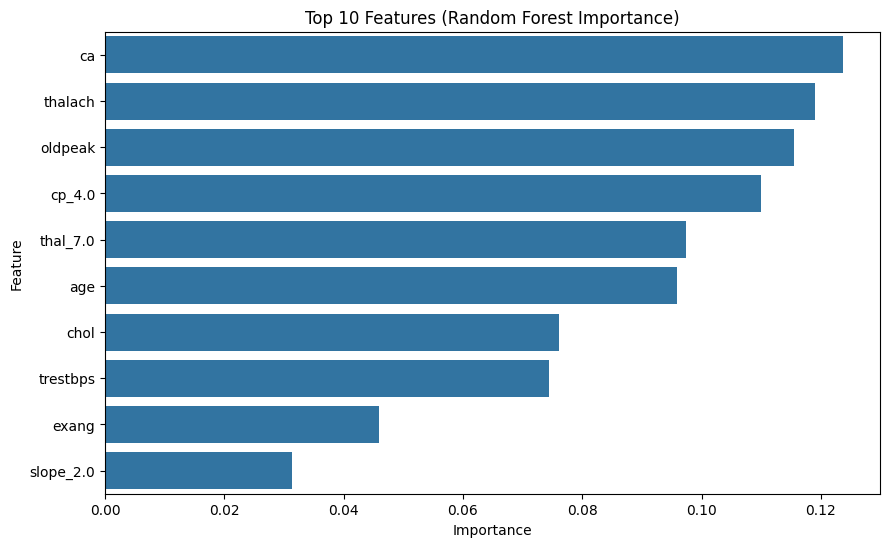

,Feature,Importance
8,ca,0.123726
5,thalach,0.119082
7,oldpeak,0.115423
11,cp_4.0,0.109910
17,thal_7.0,0.097448
0,age,0.095842
3,chol,0.076181
2,trestbps,0.074470
6,exang,0.045942
14,slope_2.0,0.031381


In [11]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plot top 10 features
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importances.head(10))
plt.title("Top 10 Features (Random Forest Importance)")
plt.show()

importances.head(10)


In [12]:
log_reg = LogisticRegression(max_iter=1000, solver="liblinear")

rfe = RFE(estimator=log_reg, n_features_to_select=10)  # choose top 10
rfe.fit(X, y)

rfe_support = rfe.get_support()
rfe_features = X.loc[:, rfe_support].columns.tolist()

print("RFE Selected Features:", rfe_features)


RFE Selected Features: ['sex', 'trestbps', 'thalach', 'exang', 'oldpeak', 'ca', 'cp_2.0', 'cp_4.0', 'slope_2.0', 'thal_7.0']


In [13]:
# Chi-Square requires non-negative values, ensure X >= 0
X_chi = X.copy()
X_chi[X_chi < 0] = 0  

chi_selector = SelectKBest(score_func=chi2, k=10)
chi_selector.fit(X_chi, y)

chi_scores = pd.DataFrame({
    "Feature": X.columns,
    "Chi2 Score": chi_selector.scores_
}).sort_values(by="Chi2 Score", ascending=False)

chi_scores.head(10)


,Feature,Chi2 Score
8,ca,59.555394
7,oldpeak,55.193104
17,thal_7.0,53.780739
6,exang,50.986646
11,cp_4.0,41.632187
9,cp_2.0,34.186442
10,cp_3.0,32.037845
5,thalach,25.516508
14,slope_2.0,21.137303
16,thal_6.0,12.029774


In [15]:
# Example: take top 10 from Random Forest
top_features = importances["Feature"].head(10).tolist()

# Build reduced dataset
selected_df = df[top_features + ["target"]]

# Save reduced dataset inside data/ folder
selected_df.to_csv("data/heart_selected.csv", index=False)

print("Final dataset saved as data/heart_selected.csv with shape:", selected_df.shape)
selected_df.head()


Final dataset saved as data/heart_selected.csv with shape: (297, 11)


,ca,thalach,oldpeak,cp_4.0,thal_7.0,age,chol,trestbps,exang,slope_2.0,target
0,-0.721976,0.017494,1.068965,-0.957146,-0.794901,0.936181,-0.276443,0.750380,-0.696419,-0.925338,0
1,2.478425,-1.816334,0.381773,1.044772,-0.794901,1.378929,0.744555,1.596266,1.435916,1.080686,1
2,1.411625,-0.899420,1.326662,1.044772,1.258018,1.378929,-0.353500,-0.659431,1.435916,1.080686,1
3,-0.721976,1.633010,2.099753,-0.957146,-0.794901,-1.941680,0.051047,-0.095506,-0.696419,-0.925338,0
4,-0.721976,0.978071,0.295874,-0.957146,-0.794901,-1.498933,-0.835103,-0.095506,-0.696419,-0.925338,0
